<font size=3>This notebook presents a hyperparameter search method for finding optimal hyperparameters for my network trained on churn. The techniques I used are same as model_nas.
The space has limited to:
 - Learning rate: 1e-5 - 1e-3
 - Dropout probability: 5e-2 - 0.15

epochs, and batch_size are omitted as this is a PoC for hyperparameter with GA. The process takes time. For making better results, one can increase <b>MAX_GENERATIONS</b>, <b>POPULATION_SIZE</b>, and <b>epochs</b> size.

I used selected optimizer, loss function, and activation functions in model_nas.
</font>
Found parameters increases accuracy to 83 by 6 epochs.

In [1]:
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt
import seaborn as sns

import random
import pandas
import numpy

import torch
import torch.nn as nn

from util import util, torch_model_arch, elitism


#### Preparation

In [2]:
data = pandas.read_csv(util.dataset_filename)
data.drop(['customerID'], axis=1, inplace=True)

data[util.target_column] = data[util.target_column].replace(['Yes', 'No'], [1.0, 0.0])
data = util.integrating_numerical_column(util.numerical_columns[0], data)
data = util.standard_rescaling(util.numerical_columns, data)
data = util.one_hot_encoding(util.categorized_columns, data)

#### Tensors' journey

In [3]:
batch_size = 5
epochs = 6
test_prob = 0.1
train_loader, test_loader, input_size, \
    classifiers_size, test_size = util.data_splitter_tensor_binary(data, util.target_column, batch_size, test_prob)


def feedback(lr, dropout_prob):
    torch.manual_seed(util.seed)
    model = torch_model_arch.net_search(input_size, classifiers_size, dropout_prob, [nn.Tanh, nn.ReLU])
    model.to(util.device)
    model_loss = nn.CrossEntropyLoss().to(util.device)
    model_optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader, 0):
            outputs = model(inputs)
            loss = model_loss(outputs, labels)
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()

    model.eval()
    y_test = []
    y_pred = []
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            logits = model(inputs)
            batch_pred = torch.argmax(logits, dim=1)
            batch_labels = torch.argmax(labels, dim=1)
            y_test.extend(batch_labels.cpu().tolist())
            y_pred.extend(batch_pred.cpu().tolist())
            correct += (batch_pred == batch_labels).sum().item()

    return correct/test_size

#### Search

gen	nevals	max    	avg   
0  	30    	0.82695	0.8174
1  	23    	0.82695	0.81948
2  	24    	0.82695	0.820662
3  	23    	0.82695	0.821655
4  	22    	0.828369	0.8226  
5  	21    	0.828369	0.82227 
6  	21    	0.828369	0.822884
7  	24    	0.828369	0.823783
8  	20    	0.828369	0.823593
9  	17    	0.828369	0.825296
10 	23    	0.828369	0.823452
11 	23    	0.828369	0.825248
12 	21    	0.828369	0.824917
13 	22    	0.828369	0.824917
14 	20    	0.829787	0.824397
15 	20    	0.829787	0.825437
16 	22    	0.829787	0.824634
17 	25    	0.829787	0.823262
18 	22    	0.829787	0.823972
19 	24    	0.829787	0.824019
20 	22    	0.829787	0.82539 
21 	23    	0.829787	0.824775
22 	19    	0.829787	0.82539 
23 	21    	0.829787	0.825674
24 	22    	0.829787	0.825957
25 	23    	0.829787	0.826336
26 	23    	0.831206	0.825012
27 	20    	0.831206	0.826194
28 	23    	0.831206	0.826241
29 	18    	0.831206	0.826478
30 	18    	0.831206	0.827754
- Best learning rate, and dropout: 
[3.8093424453229945e-05, 0.05195051965108121] 

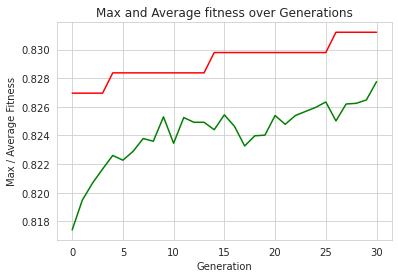

In [4]:
def fitness_func(vals):
    return feedback(*vals),

# Learing_rate, dropout
BOUNDS_LOW =  [1e-5, 5e-2]
BOUNDS_HIGH = [1e-3, 0.16]


NUM_OF_PARAMS = len(BOUNDS_HIGH)

POPULATION_SIZE = 30
P_CROSSOVER = 0.7
P_MUTATION = 0.5
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0  # crowding factor for crossover and mutation

toolbox = base.Toolbox()

creator.create('fitness_max', base.Fitness, weights=(1.0,))

creator.create('individual', list, fitness=creator.fitness_max)

for i in range(NUM_OF_PARAMS):
    toolbox.register('param_' + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes = attributes + (toolbox.__getattribute__('param_' + str(i)),)

toolbox.register('individual_creator',
                 tools.initCycle,
                 creator.individual,
                 attributes,
                 n=1)

toolbox.register('population_creator', tools.initRepeat, list, toolbox.individual_creator)


toolbox.register('evaluate', fitness_func)


toolbox.register('select', tools.selTournament, tournsize=2)
toolbox.register('mate',
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register('mutate',
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)


def main():
    population = toolbox.population_creator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('max', numpy.max)
    stats.register('avg', numpy.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = elitism.eaSimpleWithElitism(\
        population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    print('- Best learning rate, and dropout: ')
    print(hof.items[0], sum(hof.items[0])/len(hof.items[0]))
    print(f'Accuracy = {hof.items[0].fitness.values[0]}')

    max_fit, mean_fit = logbook.select('max', 'avg')

    sns.set_style('whitegrid')
    plt.plot(max_fit, color='red')
    plt.plot(mean_fit, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()


main()


~0.83. My own choice was 1e-5 for lr and 0.15 for dropout_prob

In [5]:
lr = 3.8093424453229945e-05
dropout_prob = 0.05195051965108121
feedback(lr, dropout_prob)

0.8312056737588652